# Data Prep
Start by loading in papers as pickled in arxiv-sanity scripts.

In [101]:
import pickle
NUM_PAPERS = 5000

db = pickle.load(open("db.p", 'rb'))
papers = [(ID, paper) for (ID, paper) in sorted(db.items())[:NUM_PAPERS]]

Get the set of all words across document abstracts and tokenize the abstracts.

Remove stop words, remove punctuation, stem words.

In [102]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation)
stemmer = SnowballStemmer("english")

words = set()
for index, (ID, paper) in enumerate(papers):
    sent_text = nltk.sent_tokenize(paper["summary"].lower())
    tokenized = []
    paper["doc_contains_word"] = set()
    for sentence in sent_text:
        tokenized_text = nltk.word_tokenize(sentence)
        for token in tokenized_text:
            token = stemmer.stem(token)
            if token in stop_words:
                continue
            if token in punctuation:
                continue
            words.add(token)
            tokenized.append(token)
            paper["doc_contains_word"].add(token)
    papers[index][1]["tokenized"] = tokenized

RANDOM_ABSTRACT = 20
print("Words in corpus: %s" % [word for word in words][:10] )
print("Tokenized abstract: %s" % papers[RANDOM_ABSTRACT][1]["tokenized"] )

Words in corpus: ['indoor67', 'descatt', 'term-docu', 'saudi', 'tmcm', 'rusu', 'top', 'micro-aeri', 'hjb', 'hall']
Tokenized abstract: ['present', 'imag', 'represent', 'method', 'deriv', 'analyz', 'gaussian', 'probabl', 'densiti', 'function', '\\emph', 'pdf', 'space', 'use', 'lie', 'group', 'theori', 'propos', 'method', 'imag', 'model', 'gaussian', 'mixtur', 'model', 'gmms', 'adapt', 'global', 'train', 'gmm', 'call', 'univers', 'background', 'model', 'ubm', 'vector', 'gmms', 'base', 'two', 'fact', '1', 'compon', 'image-specif', 'gmms', 'close', 'group', 'togeth', 'around', 'correspond', 'compon', 'ubm', 'due', 'characterist', 'ubm', 'adapt', 'procedur', '2', 'gaussian', '\\emph', 'pdf', 'form', 'lie', 'group', 'differenti', 'manifold', 'rather', 'vector', 'space', 'map', 'gaussian', 'compon', 'tangent', 'vector', 'space', 'name', 'lie', 'algebra', 'lie', 'group', 'manifold', 'posit', 'ubm', 'final', 'featur', 'vector', 'name', 'lie', 'algebr', 'gaussian', 'lag', 'construct', 'combin', 

# Term Frequency Inverse Document Frequency

Calculate the Inverse Document Frequency

In [103]:
word_to_doc_count = {}
for word in words:
    if word not in word_to_doc_count:
        word_to_doc_count[word] = 0
    for _, paper in papers:
        if word in paper["doc_contains_word"]:
            word_to_doc_count[word] += 1

print("word_to_doc_freq: %s" % [(k, v) for k, v in word_to_doc_count.items()][:5])

word_to_doc_freq: [('indoor67', 3), ('term-docu', 1), ('saudi', 1), ('hjb', 1), ('descatt', 1)]


In [104]:
import math
inv_doc_freq = {}
for word, doc_count in word_to_doc_count.items():
    inv_doc_freq[word] = math.log10((len(papers) + 2) / (1 + doc_count))

print("inv_doc_freq: %s" % ", ".join(["(%s, %.4f)" % (k, v) for k, v in inv_doc_freq.items()][:5]))

inv_doc_freq: (indoor67, 3.0971), (term-docu, 3.3981), (picosecond, 3.3981), (saudi, 3.3981), (hjb, 3.3981)


Create a mapping of words to indices and vice versa.

In [105]:
word2ix = {}
count = 0
for word in words:
    word2ix[word] = count
    count += 1
ix2word = {value:key for key, value in word2ix.items()}

print("word2ix: %s" % [(k, v) for k, v in word2ix.items()][:5])
print("ix2word: %s" % [(k, v) for k, v in ix2word.items()][:5])

word2ix: [('indoor67', 0), ('term-docu', 2), ('saudi', 3), ('hjb', 8), ('descatt', 1)]
ix2word: [(0, 'indoor67'), (1, 'descatt'), (2, 'term-docu'), (3, 'saudi'), (4, 'tmcm')]


Calculate actual TFIDF.

In [106]:
# Rows are documents. Columns are words.
tfidf_matrix = [[0 for _ in range(len(words))] for _ in range(len(papers))]

# Add up the term frequencies.
index_total = {i: 0 for i in range(len(papers))}
for index, (ID, paper) in enumerate(papers):
    for token in paper["tokenized"]:
        tfidf_matrix[index][word2ix[token]] += 1
        index_total[index] += 1

In [107]:
# Multiply by IDF
for doc_ix in range(len(papers)):
    for word_ix in range(len(words)):
        tfidf_matrix[doc_ix][word_ix] = tfidf_matrix[doc_ix][word_ix] * inv_doc_freq[ix2word[word_ix]]

In [108]:
import numpy as np
np_tfidf_matrix = np.array(tfidf_matrix)

/Users/calvin/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


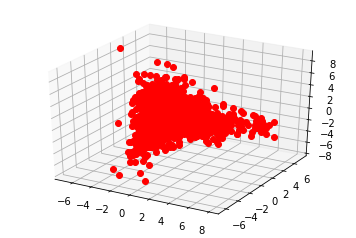

In [109]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
X = np_tfidf_matrix
pca = PCA(n_components=3)
pca.fit(X)
X = pca.transform(np_tfidf_matrix)
x0, y0, z0 = zip(*X)
fig = plt.figure()
fig.clear()

from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
plt.plot(x0, y0, z0, "ro")
fig

# Cluster

In [110]:
X = np_tfidf_matrix

In [111]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [112]:
labels = kmeans.labels_
label_to_papers = {i:[] for i in range(kmeans.n_clusters)}
for index, (ID, paper) in enumerate(papers):
    label_to_papers[labels[index]].append((index, paper))

from collections import Counter
most_common = {}
print("Most common words in each cluster")
for label in range(kmeans.n_clusters):
    word_counts = None
    for _, paper in label_to_papers[label]:
        counts = Counter(paper["tokenized"])
        if word_counts is None:
            word_counts = counts
        else:
            word_counts += counts
    print("Label %d: %s" % (label, ", ".join([word for word, count in word_counts.most_common(10)])))

Most common words in each cluster
Label 0: model, use, learn, method, algorithm, data, propos, network, problem, show
Label 1: sampl, \right, 1, -1, complex, -arm, best-, ent, instanc, h
Label 2: imag, use, propos, method, model, network, learn, featur, object, dataset


In [113]:
print("Sum of tfidf scores of words in each cluster, sorted")
for label in range(kmeans.n_clusters):
    word_tfidf_cluster = {}
    for word in words:
        if word not in word_tfidf_cluster:
            word_tfidf_cluster[word] = 0
        for index, _ in label_to_papers[label]:
            word_tfidf_cluster[word] += tfidf_matrix[index][word2ix[word]]
    highest_tfidf_values = list(reversed(sorted([(v, k) for k, v in word_tfidf_cluster.items()])))[:10]
    print("Label %d: %s" % (label, ", ".join([word for sum_tfidf, word in highest_tfidf_values]))   )

Sum of tfidf scores of words in each cluster, sorted
Label 0: model, algorithm, learn, data, network, method, problem, optim, function, system
Label 1: \right, best-, -arm, -1, ent, \ln\delta^, \cdot\left, h, gap-entropi, +\mathsf
Label 2: imag, video, object, segment, detect, featur, 3d, visual, network, face


In [114]:
# Paper closest to center of a cluster
for label in range(kmeans.n_clusters):
    minimum_index = None
    minimum = None
    for index, paper in label_to_papers[label]:
        dist = np.sum(np.abs(kmeans.cluster_centers_[label] - X[index]))
        if minimum is None or dist < minimum:
            minimum_index = index
            minimum = dist
    print("Closest to center %d: %s" % (label, papers[minimum_index][1]["title"]))

Closest to center 0: Deep Neural Networks - A Brief History
Closest to center 1: Towards Instance Optimal Bounds for Best Arm Identification
Closest to center 2: 3D Fully Convolutional Network for Vehicle Detection in Point Cloud


In [115]:
for i in range(kmeans.n_clusters):
    print("Size of cluster %d" % len(label_to_papers[i]))

Size of cluster 3862
Size of cluster 1
Size of cluster 1137


# Dimensionality Reduction & t-SNE

In [116]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
X = np_tfidf_matrix
pca = PCA(n_components=128)
pcaX = pca.fit_transform(X)

In [117]:
model = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)
tX = model.fit_transform(pcaX)

/Users/calvin/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


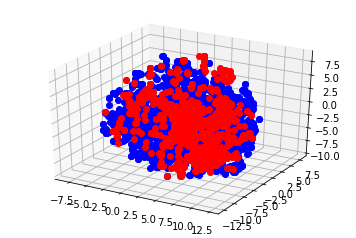

In [118]:
import itertools

plt.close()
fig = plt.figure()
fig.clear()

fig = plt.figure()
fig.clear()
ax = fig.add_subplot(111, projection='3d')
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

def plotNextLabel(label, c=colors):
    color = next(c)
    X = [ tX[index] for index, _ in label_to_papers[label][:][:] ]
    x0, y0, z0 = zip(*X)
    plt.plot(x0, y0, z0, color + "o")

[plotNextLabel(i) for i in range(kmeans.n_clusters)]
fig